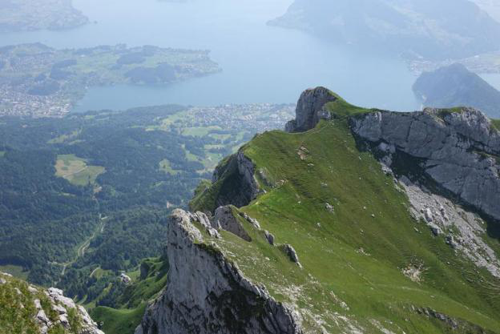

开始做梦...
Step 10/100,loss 1.1977722644805908
Step 20/100,loss 1.4992499351501465
Step 30/100,loss 1.6880056858062744
Step 40/100,loss 1.82438325881958
Step 50/100,loss 1.9350459575653076
Step 60/100,loss 2.0233747959136963
Step 70/100,loss 2.103604555130005
Step 80/100,loss 2.170109510421753
Step 90/100,loss 2.229518413543701
Step 100/100,loss 2.2852330207824707
梦醒时分....


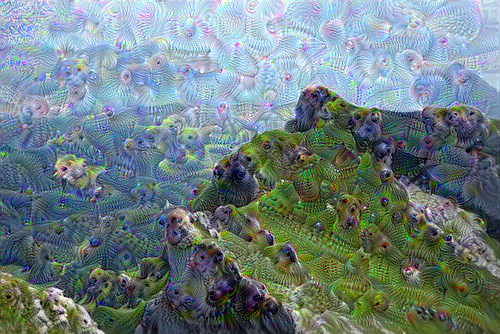

In [1]:
import tensorflow as tf
import numpy as np
import IPython.display as display
import PIL.Image
import time
from tensorflow.keras.preprocessing import image
#图像标准化
def normalize_image(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img,tf.uint8)
#图像可视化
def show_image(img):
    display.display(PIL.Image.fromarray(np.array(img)))
#保存图像文件
def save_image(img,file_name):
    PIL.Image.fromarray(np.array(img)).save(file_name)

#读取图像
def read_image(file_name,max_dim=None):
    img = PIL.Image.open(file_name)
    if max_dim:
        img.thumbnail((max_dim,max_dim))
    return np.array(img)

image_file ="E:/TestData/mountain.jpg"
original_img=read_image(image_file,max_dim=500)
show_image(original_img)

#导入V3模型
base_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
# base_model.summary()

layer_names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in layer_names]

#创建特征提取模型
dream_model = tf.keras.Model(inputs=base_model.input,outputs=layers)

def calc_loss(img,model):
    #对图像做变形，由（300，300，3）扩展为（1-样本数，300，300，3）
    img=tf.expand_dims(img,axis=0)
    #图像通过模型前向传播得到计算结果
    layer_activations = model(img)
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
        #返回选中每通道的计算结果
    return tf.reduce_sum(losses)


# 定义图像优化过程函数
def render_deepdream(model, img, steps=100, step_size=0.01, verbose=1):
    for n in tf.range(steps):
        with tf.GradientTape() as tape:
            # 对img进行梯度变换
            tape.watch(img)
            loss = calc_loss(img, model)
        # 计算损失相对于输入图像像素的梯度
        gradients = tape.gradient(loss, img)

        # 归一化梯度值
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        # 在梯度上升中，损失值越来越大，因此可以直接添加损失值到图像中，因为他们的shape相同
        img = img + gradients * step_size
        img = tf.clip_by_value(img, -1, 1)

        # 输出过程提示信息
        if (verbose == 1):
            if ((n + 1) % 10 == 0):
                print("Step {}/{},loss {}".format(n + 1, steps, loss))
    return img

img = tf.keras.applications.inception_v3.preprocess_input(original_img)
img = tf.convert_to_tensor(img)
start = time.time()
print("开始做梦...")
# 调用优化过程
dream_img = render_deepdream(dream_model, img, steps=100, step_size=0.01)
end = time.time()
end - start
print("梦醒时分....")
# 标准化图像
dream_img = normalize_image(dream_img)
# 显示结果图像
show_image(dream_img)
# 保存结果图像
# file_name = 'deepdream_{}.jpg'.format(layer_names)
# save_image(dream_img, file_name)
# print("环境已保存为：".format(file_name))